In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import os
import librosa
import torch.optim as optim

In [2]:
gesture_train_frame = pd.read_csv('/kaggle/input/geaturedata/GestureDataset.csv')
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

cuda:0


In [3]:
!pip3 install ax-platform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.9/631.9 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.1/274.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2

In [4]:
from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.service.utils.report_utils import exp_to_df
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.utils.tutorials.cnn_utils import evaluate, train

[WARNING 07-27 17:44:31] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [5]:
class GestureDataset(Dataset):

    def __init__(self, file, transform=None):

        self.train_frame = pd.read_csv(file)
        
        data = self.train_frame[['x', 'y', 'z']].values
        
        gestures = []
        labels = []
        
        num_points_per_gesture = 21
        
        for i in range(0, len(data), num_points_per_gesture):
            gesture = data[i:i + num_points_per_gesture]
            gestures.append(gesture)
            labels.append(self.train_frame.iloc[i,5])
            
        self.gestures_data = gestures
        self.labels = labels


    def __len__(self):
        return len(self.gestures_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()

        input_values = self.gestures_data[idx]
        label = self.labels[idx]

        return torch.tensor(input_values).to(device),torch.tensor(label).to(device)

In [6]:
gestureDataset = GestureDataset('/kaggle/input/geaturedata/GestureDataset.csv')
gestureTestDataset = GestureDataset('/kaggle/input/geaturedata/TestingGestureDataset.csv')

In [7]:
gestureDataset[600]

(tensor([[ 4.1905e-01,  9.1587e-01,  1.1254e-07],
         [ 4.7514e-01,  8.8671e-01, -3.2379e-02],
         [ 5.2244e-01,  8.3007e-01, -5.9935e-02],
         [ 5.0662e-01,  7.8667e-01, -8.6392e-02],
         [ 4.6574e-01,  7.7398e-01, -1.1069e-01],
         [ 4.7473e-01,  6.7507e-01, -5.2990e-02],
         [ 4.8038e-01,  5.7000e-01, -9.0287e-02],
         [ 4.8572e-01,  5.0156e-01, -1.1202e-01],
         [ 4.8494e-01,  4.3971e-01, -1.2836e-01],
         [ 4.1409e-01,  6.7404e-01, -5.8946e-02],
         [ 4.4957e-01,  6.9960e-01, -1.0181e-01],
         [ 4.6321e-01,  7.6670e-01, -1.1086e-01],
         [ 4.5537e-01,  7.7257e-01, -1.1235e-01],
         [ 3.7047e-01,  7.0731e-01, -6.7651e-02],
         [ 4.1645e-01,  7.6373e-01, -1.0650e-01],
         [ 4.3601e-01,  8.1513e-01, -9.8336e-02],
         [ 4.2961e-01,  8.0662e-01, -8.8753e-02],
         [ 3.3879e-01,  7.5612e-01, -8.0172e-02],
         [ 3.8289e-01,  8.1576e-01, -1.0579e-01],
         [ 4.0518e-01,  8.5100e-01, -9.8729e-02],


In [8]:
train_loader = DataLoader(gestureDataset, batch_size=1, shuffle=True)
val_loader = DataLoader(gestureTestDataset, batch_size=1, shuffle=True)

In [9]:
# all_data_loader = DataLoader(gestureDataset, batch_size=1, shuffle=True)
# train_dataset = all_data_loader.dataset
# validation_size = int(len(train_dataset) * 0.1)

# train_size = len(train_dataset) - validation_size
# train_subset, val_subset = random_split(all_data_loader.dataset, [train_size, validation_size])

# train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
# val_loader = DataLoader(val_subset, batch_size=1, shuffle=True)

In [10]:
train_loader.dataset[0]

(tensor([[ 1.0712e-01,  2.6895e-01, -1.4400e-07],
         [ 1.6129e-01,  2.1211e-01,  2.8886e-03],
         [ 1.7530e-01,  1.4249e-01,  2.7124e-03],
         [ 1.6051e-01,  9.0664e-02,  1.8644e-03],
         [ 1.4134e-01,  7.4432e-02,  6.6918e-04],
         [ 1.4786e-01,  4.3135e-02,  2.6917e-03],
         [ 1.3749e-01,  4.1132e-02,  6.9247e-04],
         [ 1.3920e-01,  7.4606e-02, -7.9654e-03],
         [ 1.4014e-01,  9.6006e-02, -1.5147e-02],
         [ 1.0368e-01,  4.6748e-02, -9.4866e-04],
         [ 1.0096e-01,  5.2555e-02,  7.3673e-03],
         [ 1.0484e-01,  8.3868e-02,  5.4739e-03],
         [ 1.0616e-01,  1.0814e-01,  1.8586e-04],
         [ 6.5282e-02,  6.9633e-02, -3.5994e-03],
         [ 6.7650e-02,  7.6857e-02,  4.3392e-03],
         [ 7.4562e-02,  1.0260e-01,  7.0513e-03],
         [ 7.7843e-02,  1.2598e-01,  5.1960e-03],
         [ 3.4193e-02,  9.8604e-02, -6.4348e-03],
         [ 3.8955e-02,  9.3373e-02,  7.2946e-04],
         [ 4.7369e-02,  1.1801e-01,  9.7352e-03],


In [11]:
class GestureCNN(nn.Module):
    def __init__(self, c1, c2, l1, ks):
        super(GestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c1, kernel_size=(ks, 3), stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=c1, out_channels=c2, kernel_size=(ks, 3), stride=1, padding='same')
        self.fc1 = nn.Linear(c2 * 21 * 3, l1)
        self.fc2 = nn.Linear(l1, 41)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
#         x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
#         x = self.maxpool(x)
        
        x = x.view(-1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

In [12]:
import datetime
epoch_print_gap = 1

def training_loop(n_epochs, parameters, model, device, loss_fn, train_loader):
    model = model.to(device).train()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for inputs, labels in train_loader:
            outputs = model(inputs.to(device).float())
            loss = loss_fn(torch.unsqueeze(outputs, 0), labels.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

#         if epoch == 1 or epoch % epoch_print_gap == 0:
#             print('{} Epoch {}, Training loss {}'.format(
#               datetime.datetime.now(), epoch, float(loss_train)))
            
    
    return model

In [13]:
def evaluate_loop(model, device, test_loader):
    model.eval()
    model = model.to(device)
    correct = 0
    count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            output = model(inputs)
            pred = output.argmax()
            count += 1
            if pred == labels:
                correct += 1

#     print('\evaluate set: Accuracy: {}/{} ({:.0f}%)\n'.format(
#         correct, len(test_loader.dataset),
#         100. * correct / count))
    return 100. * correct / count

In [14]:
def train_evaluate(parameterization):
  net = GestureCNN(parameterization['c1'],parameterization['c2'],parameterization['l1'],parameterization['ks'])
  net = net.float()
  loss_fn = nn.CrossEntropyLoss()
  net = training_loop(n_epochs=3,
                      parameters=parameterization,
                      model=net,
                      device=device,
                      loss_fn=loss_fn,
                      train_loader=train_loader)

  return evaluate_loop(model=net,
                         device = device,
                         test_loader = val_loader)

In [15]:
def training_val_loop(n_epochs, model, device, loss_fn, train_loader, val_loader):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    for epoch in range(1, n_epochs + 1):
      loss_train = 0.0
      val_train = 0.0
      for inputs, labels in train_loader:
        outputs = model(inputs.to(device).float())
        loss = loss_fn(torch.unsqueeze(outputs, 0), labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        
      for inputs, labels in val_loader:
        outputs = model(inputs.to(device).float())
        loss = loss_fn(torch.unsqueeze(outputs, 0), labels.to(device))

        val_train += loss.item()

      if epoch == 1 or epoch % epoch_print_gap == 0:
        print('{} Epoch {}, Training loss {}, Validation loss {}'.format(
          datetime.datetime.now(), epoch, float(loss_train), float(val_train)))
        evaluate_loop(model, device, val_loader)
    return model

In [16]:
ax_client = AxClient()
# Create an experiment with required arguments: name, parameters, and objective_name.
ax_client.create_experiment(
    name="tune_cnn",  # The name of the experiment.
    parameters=[
        {
            "name": "c1",  # The name of the parameter.
            "type": "range",  # The type of the parameter ("range", "choice" or "fixed").
            "bounds": [10, 80],  # The bounds for range parameters.
            # "values" The possible values for choice parameters .
            # "value" The fixed value for fixed parameters.
            "value_type": "int"
        },
        {
            "name": "c2",  # The name of the parameter.
            "type": "range",  # The type of the parameter ("range", "choice" or "fixed").
            "bounds": [10, 80],  # The bounds for range parameters.
            # "values" The possible values for choice parameters .
            # "value" The fixed value for fixed parameters.
            "value_type": "int"
        },
        {
            "name": "l1",  # The name of the parameter.
            "type": "range",  # The type of the parameter ("range", "choice" or "fixed").
            "bounds": [20, 500],  # The bounds for range parameters.
            # "values" The possible values for choice parameters .
            # "value" The fixed value for fixed parameters.
            "value_type": "int"
        },
        {
            "name": "ks",  # The name of the parameter.
            "type": "choice",  # The type of the parameter ("range", "choice" or "fixed").
            "values": [3,5,7,9],  # The bounds for range parameters.
            # "values" The possible values for choice parameters .
            # "value" The fixed value for fixed parameters.
            "value_type": "int",
            "is_ordered": True,
            "sort_values": True
        }
    ],
    objectives={"accuracy": ObjectiveProperties(minimize=False)},  # The objective name and minimization setting.
    # outcome_constraints: Optional, a list of strings of form "constrained_metric <= some_bound".
)

[INFO 07-27 17:44:32] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 07-27 17:44:32] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='c1', parameter_type=INT, range=[10, 80]), RangeParameter(name='c2', parameter_type=INT, range=[10, 80]), RangeParameter(name='l1', parameter_type=INT, range=[20, 500]), ChoiceParameter(name='ks', parameter_type=INT, values=[3, 5, 7, 9], is_ordered=True, sort_values=True)], parameter_constraints=[]).
[INFO 07-27 17:44:32] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 07-27 17:44:32] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials

In [17]:
# Attach the trial
ax_client.attach_trial(
    parameters={"c1":10, "c2":20, "l1":100, 'ks':3}
)

# Get the parameters and run the trial
baseline_parameters = ax_client.get_trial_parameters(trial_index=0)
ax_client.complete_trial(trial_index=0, raw_data=train_evaluate(baseline_parameters))

[INFO 07-27 17:44:32] ax.core.experiment: Attached custom parameterizations [{'c1': 10, 'c2': 20, 'l1': 100, 'ks': 3}] as trial 0.
[INFO 07-27 17:45:06] ax.service.ax_client: Completed trial 0 with data: {'accuracy': (83.898305, None)}.


In [18]:
for i in range(200):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=train_evaluate(parameters))

/opt/conda/lib/python3.10/site-packages/ax/modelbridge/cross_validation.py:462: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 07-27 17:45:06] ax.service.ax_client: Generated new trial 1 with parameters {'c1': 15, 'c2': 43, 'l1': 109, 'ks': 3} using model Sobol.
[INFO 07-27 17:45:38] ax.service.ax_client: Completed trial 1 with data: {'accuracy': (91.271186, None)}.
/opt/conda/lib/python3.10/site-packages/ax/modelbridge/cross_validation.py:462: UserWarning:

Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.

[INFO 07-27 17:45:38] ax.service.ax_client: Generated new trial 2 with parameters {'c1': 41, 'c2': 65, 'l1': 472, 'ks': 9} using model Sobol.
[INFO 07-27 17:46:14] ax.service.ax_client: Completed trial 2 with data: {'accuracy': (95.974576, None)}.
/opt/conda/lib/python3.10/site-packages/ax/modelbridge/cross_validation.py:462: UserWarning:

Encountered except

In [19]:
ax_client.get_trials_data_frame()

[WARNING 07-27 19:58:43] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,accuracy,c1,c2,l1,ks
0,0,0_0,COMPLETED,Manual,83.898305,10,20,100,3
1,1,1_0,COMPLETED,Sobol,91.271186,15,43,109,3
2,2,2_0,COMPLETED,Sobol,95.974576,41,65,472,9
3,3,3_0,COMPLETED,Sobol,93.050847,31,34,241,3
4,4,4_0,COMPLETED,Sobol,94.533898,78,46,157,3
...,...,...,...,...,...,...,...,...,...
196,196,196_0,COMPLETED,BoTorch,88.940678,27,74,321,5
197,197,197_0,COMPLETED,BoTorch,97.372881,27,26,342,7
198,198,198_0,COMPLETED,BoTorch,97.415254,10,10,345,5
199,199,199_0,COMPLETED,BoTorch,97.881356,22,47,339,3


In [20]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters

{'c1': 10, 'c2': 62, 'l1': 487, 'ks': 5}

In [21]:
mean, covariance = values
mean, covariance

({'accuracy': 98.59154240142519},
 {'accuracy': {'accuracy': 0.26228108479239204}})

In [22]:
def training_loop_with_loss_accuracy(n_epochs, parameters, model, device, loss_fn, train_loader):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    loss_list = []
    train_accuracy = []
    val_accuracy = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for inputs, labels in train_loader:
            outputs = model(inputs.to(device).float())
            loss = loss_fn(torch.unsqueeze(outputs, 0), labels.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()


        taccuracy = evaluate_loop(model=model,
                                 device = device,
                                 test_loader = train_loader)
        accuracy = evaluate_loop(model=model,
                                 device = device,
                                 test_loader = val_loader)
        loss_list.append(loss_train)
        train_accuracy.append(taccuracy)
        val_accuracy.append(accuracy)
        print('{} Epoch {}, Training loss {}, train_accuracy {}, val_accuracy {}'.format(
          datetime.datetime.now(), epoch, float(loss_train),taccuracy,accuracy))
    return model,loss_list,train_accuracy,val_accuracy

In [23]:
net = GestureCNN(best_parameters['c1'],best_parameters['c2'],best_parameters['l1'],best_parameters['ks'])
net = net.to(device).float()
loss_fn = nn.CrossEntropyLoss()
net,loss,train_accuracy,val_accuracy = training_loop_with_loss_accuracy(n_epochs=40,
                    parameters=best_parameters,
                    model=net,
                    device=device,
                    loss_fn=loss_fn,
                    train_loader=train_loader)

2024-07-27 19:59:06.667602 Epoch 1, Training loss 7795.310650572893, train_accuracy 94.14893617021276, val_accuracy 89.57627118644068
2024-07-27 19:59:22.471307 Epoch 2, Training loss 444.9786352106088, train_accuracy 99.55319148936171, val_accuracy 95.88983050847457
2024-07-27 19:59:38.336773 Epoch 3, Training loss 311.16819562168007, train_accuracy 99.55319148936171, val_accuracy 97.54237288135593
2024-07-27 19:59:54.235604 Epoch 4, Training loss 255.90414182632014, train_accuracy 99.68085106382979, val_accuracy 96.3135593220339
2024-07-27 20:00:10.032387 Epoch 5, Training loss 149.16219963371776, train_accuracy 99.76595744680851, val_accuracy 97.11864406779661
2024-07-27 20:00:25.783352 Epoch 6, Training loss 183.88524494469638, train_accuracy 99.76595744680851, val_accuracy 96.1864406779661
2024-07-27 20:00:41.622140 Epoch 7, Training loss 182.43997455884642, train_accuracy 99.44680851063829, val_accuracy 96.94915254237289
2024-07-27 20:00:57.321810 Epoch 8, Training loss 109.54879

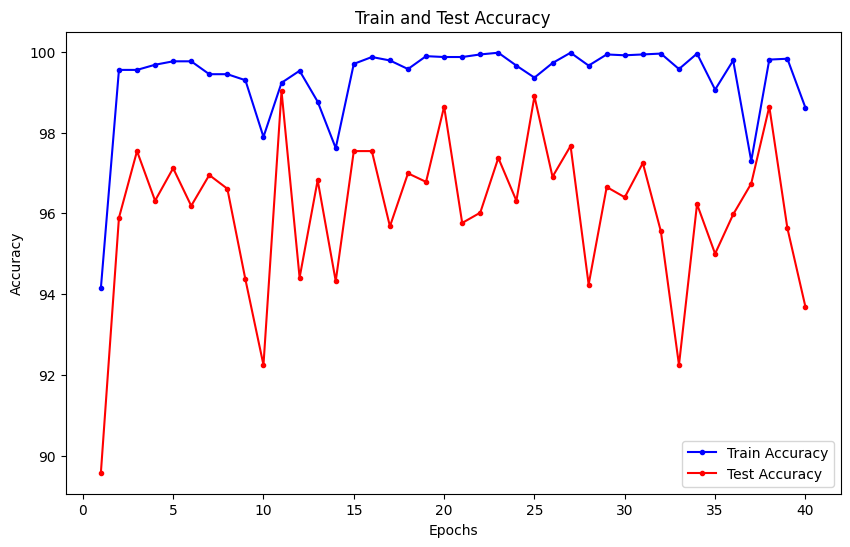

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, 41)

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue', marker='.')
plt.plot(epochs, val_accuracy, label='Test Accuracy', color='red', marker='.')

plt.title('Train and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.savefig('train_test_accuracy.png')
plt.show()

In [25]:
gestureModel = GestureCNN(best_parameters['c1'],best_parameters['c2'],best_parameters['l1'],best_parameters['ks'])
gestureModel = gestureModel.to(device).float()
loss_fn = nn.CrossEntropyLoss()
gestureModel,loss,train_accuracy,val_accuracy = training_loop_with_loss_accuracy(n_epochs=15,
                    parameters=best_parameters,
                    model=gestureModel,
                    device=device,
                    loss_fn=loss_fn,
                    train_loader=train_loader)

2024-07-27 20:09:39.738573 Epoch 1, Training loss 7725.473350666726, train_accuracy 97.42553191489361, val_accuracy 94.53389830508475
2024-07-27 20:09:55.609207 Epoch 2, Training loss 382.52073479496266, train_accuracy 94.29787234042553, val_accuracy 94.19491525423729
2024-07-27 20:10:11.480900 Epoch 3, Training loss 294.300271308342, train_accuracy 99.19148936170212, val_accuracy 96.61016949152543
2024-07-27 20:10:27.370694 Epoch 4, Training loss 238.4325271255565, train_accuracy 96.44680851063829, val_accuracy 95.97457627118644
2024-07-27 20:10:43.172569 Epoch 5, Training loss 216.73346882606452, train_accuracy 99.19148936170212, val_accuracy 97.96610169491525
2024-07-27 20:10:59.038099 Epoch 6, Training loss 177.02736046269317, train_accuracy 98.1063829787234, val_accuracy 96.27118644067797
2024-07-27 20:11:14.812454 Epoch 7, Training loss 177.9107562917217, train_accuracy 99.72340425531915, val_accuracy 98.00847457627118
2024-07-27 20:11:30.708072 Epoch 8, Training loss 130.7854836

In [26]:
torch.save(gestureModel.state_dict(), 'gestureModelState.pth')